In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from transformers import T5Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
import nltk
import json
from wordcloud import WordCloud

/Users/saitriveni/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saitriveni/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
stop_words = set(stopwords.words('english'))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
# Load datasets using KaggleHub
behaviors_file_path = "MINDsmall_train/behaviors.tsv"
news_file_path = "MINDsmall_train/news.tsv"
entity_embedding_file_path = "MINDsmall_train/entity_embedding.vec"
relation_embedding_file_path = "MINDsmall_train/relation_embedding.vec"

In [5]:
# Load behaviors and news data
behaviors = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "arashnic/mind-news-dataset",
    behaviors_file_path,
    pandas_kwargs={'sep': '\t', 'header': None,
                  'names': ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']}
)
behaviors.head()

/var/folders/mf/7mxx1sb50xvct40l735sc3440000gn/T/ipykernel_90898/4053923260.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  behaviors = kagglehub.load_dataset(


100%|██████████| 32.1M/32.1M [00:01<00:00, 20.0MB/s]

Extracting zip of behaviors.tsv...


,ImpressionID,UserID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [6]:
news = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "arashnic/mind-news-dataset",
    news_file_path,
    pandas_kwargs={'sep': '\t', 'header': None,
                  'names': ['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract',
                            'URL', 'TitleEntities', 'AbstractEntities']}
)
news.head()

/var/folders/mf/7mxx1sb50xvct40l735sc3440000gn/T/ipykernel_90898/533938784.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  news = kagglehub.load_dataset(


100%|██████████| 10.2M/10.2M [00:00<00:00, 12.8MB/s]

Extracting zip of news.tsv...


,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [7]:
# Load entity and relation embeddings
entity_embeddings = {}
# Download the dataset and get the path to the entity embedding file
entity_embedding_path = kagglehub.dataset_download("arashnic/mind-news-dataset", entity_embedding_file_path)
# Open the file at the downloaded path using a context manager
with open(entity_embedding_path, 'r', encoding='utf-8') as f:
    for line in f: # Iterate directly over file lines
        parts = line.strip().split('\t')
        entity_embeddings[parts[0]] = np.array(list(map(float, parts[1:])))

relation_embeddings = {}
# Download the dataset and get the path to the relation embedding file
relation_embedding_path = kagglehub.dataset_download("arashnic/mind-news-dataset", relation_embedding_file_path)
# Open the file at the downloaded path using a context manager
with open(relation_embedding_path, 'r', encoding='utf-8') as f:
    for line in f: # Iterate directly over file lines
        parts = line.strip().split('\t')
        relation_embeddings[parts[0]] = np.array(list(map(float, parts[1:])))

100%|██████████| 8.83M/8.83M [00:00<00:00, 11.7MB/s]

Extracting zip of entity_embedding.vec...


100%|██████████| 1.00M/1.00M [00:01<00:00, 959kB/s]


In [8]:
# Data Cleaning
news = news.drop_duplicates(subset=['NewsID'])
news[['Title', 'Abstract']] = news[['Title', 'Abstract']].fillna('')

In [9]:
# Advanced Text Preprocessing
def preprocess_text(text):
    # Lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    # Named Entity Recognition
    try:
        tree = ne_chunk(pos_tag(words))
        entities = [' '.join(w for w, t in entity.leaves())
                   for entity in tree if isinstance(entity, nltk.Tree)]
    except:
        entities = []
    # T5 tokenization
    encoding = tokenizer(' '.join(words), max_length=512, truncation=True, return_tensors='np')
    return encoding['input_ids'].flatten(), words, entities

news['TitleTokens'], news['ProcessedTitle'], news['TitleNER'] = zip(*news['Title'].apply(preprocess_text))
news['AbstractTokens'], news['ProcessedAbstract'], news['AbstractNER'] = zip(*news['Abstract'].apply(preprocess_text))
news.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities,TitleTokens,ProcessedTitle,TitleNER,AbstractTokens,ProcessedAbstract,AbstractNER
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[3635, 14915, 3, 15, 13287, 9, 346, 189, 22277...","[brands, queen, elizabeth, prince, charles, pr...",[],"[1814, 16638, 7, 8094, 7, 11268, 7, 54, 17, 61...","[shop, notebooks, jackets, royals, cant, live,...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[6025, 8966, 17719, 2886, 1]","[worst, habits, belly, fat]",[],"[13045, 25708, 8966, 3609, 223, 2627, 3, 30920...","[seemingly, harmless, habits, holding, back, k...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...","[583, 3, 2666, 1167, 7, 3052, 14038, 28293, 15...","[cost, trumps, aid, freeze, trenches, ukraines...",[],"[3, 40, 17, 3, 23, 2132, 3, 4641, 3441, 1582, ...","[lt, ivan, molchanets, peeked, parapet, sand, ...",[]
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...","[3, 29, 115, 9, 2512, 270, 7, 4161, 2550, 533, 1]","[nba, wife, heres, affected, mental, health]",[],"[1800, 114, 7712, 3, 29, 115, 9, 2512, 737, 17...","[felt, like, fraud, nba, wife, didnt, help, fa...",[]
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[129, 5413, 1133, 12391, 1315, 25474, 343, 1]","[get, rid, skin, tags, according, dermatologist]",[],"[1727, 25708, 132, 7, 207, 1053, 6994, 17, 975...","[seem, harmless, theres, good, reason, shouldn...",[]


In [10]:
# TF-IDF Features
tfidf = TfidfVectorizer(max_features=1000)
news['TextCombined'] = news['ProcessedTitle'].apply(' '.join) + ' ' + news['ProcessedAbstract'].apply(' '.join)
tfidf_matrix = tfidf.fit_transform(news['TextCombined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=news['NewsID'])
news = news.join(tfidf_df, on='NewsID')

news.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities,TitleTokens,ProcessedTitle,...,yankees,yard,yards,year,yearold,years,yet,york,young,youre
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[3635, 14915, 3, 15, 13287, 9, 346, 189, 22277...","[brands, queen, elizabeth, prince, charles, pr...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[6025, 8966, 17719, 2886, 1]","[worst, habits, belly, fat]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...","[583, 3, 2666, 1167, 7, 3052, 14038, 28293, 15...","[cost, trumps, aid, freeze, trenches, ukraines...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...","[3, 29, 115, 9, 2512, 270, 7, 4161, 2550, 533, 1]","[nba, wife, heres, affected, mental, health]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[129, 5413, 1133, 12391, 1315, 25474, 343, 1]","[get, rid, skin, tags, according, dermatologist]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Process Behavior Data
behaviors['History'] = behaviors['History'].fillna('').apply(lambda x: x.split(' '))
def parse_impressions(impressions):
    return [(imp.split('-')[0], int(imp.split('-')[1])) for imp in impressions.split(' ') if imp]
behaviors['ParsedImpressions'] = behaviors['Impressions'].apply(parse_impressions)
behaviors['Time'] = pd.to_datetime(behaviors['Time'], format='%m/%d/%Y %I:%M:%S %p')
behaviors['Hour'] = behaviors['Time'].dt.hour
behaviors['Day'] = behaviors['Time'].dt.day
behaviors['Weekday'] = behaviors['Time'].dt.day_name()
behaviors['IsWeekend'] = behaviors['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
behaviors.head()

,ImpressionID,UserID,Time,History,Impressions,ParsedImpressions,Hour,Day,Weekday,IsWeekend
0,1,U13740,2019-11-11 09:05:58,"[N55189, N42782, N34694, N45794, N18445, N6330...",N55689-1 N35729-0,"[(N55689, 1), (N35729, 0)]",9,11,Monday,0
1,2,U91836,2019-11-12 18:11:30,"[N31739, N6072, N63045, N23979, N35656, N43353...",N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,"[(N20678, 0), (N39317, 0), (N58114, 0), (N2049...",18,12,Tuesday,0
2,3,U73700,2019-11-14 07:01:48,"[N10732, N25792, N7563, N21087, N41087, N5445,...",N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,"[(N50014, 0), (N23877, 0), (N35389, 0), (N4971...",7,14,Thursday,0
3,4,U34670,2019-11-11 05:28:05,"[N45729, N2203, N871, N53880, N41375, N43142, ...",N35729-0 N33632-0 N49685-1 N27581-0,"[(N35729, 0), (N33632, 0), (N49685, 1), (N2758...",5,11,Monday,0
4,5,U8125,2019-11-12 16:11:21,"[N10078, N56514, N14904, N33740]",N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,"[(N39985, 0), (N36050, 0), (N16096, 0), (N8400...",16,12,Tuesday,0


In [12]:
# Create User Profiles and Binary Interaction Vectors
user_profiles = {}
user_interactions = {}
for _, row in behaviors.iterrows():
    user_id = row['UserID']
    history = row['History']
    impressions = row['ParsedImpressions']
    if user_id not in user_profiles:
        user_profiles[user_id] = []
        user_interactions[user_id] = []
    user_profiles[user_id].extend([h for h in history if h])
    user_interactions[user_id].extend([(news_id, clicked) for news_id, clicked in impressions])
user_profiles = {user: list(set(history)) for user, history in user_profiles.items()}

user_profiles_df = pd.DataFrame(list(user_profiles.items()), columns=['UserID', 'History'])
user_profiles_df.head()

,UserID,History
0,U13740,"[N19347, N55189, N34694, N42782, N63302, N1844..."
1,U91836,"[N48742, N41011, N58715, N45099, N21773, N4270..."
2,U73700,"[N46616, N26378, N7563, N62058, N33164, N25792..."
3,U34670,"[N53880, N2203, N29757, N51891, N31825, N41375..."
4,U8125,"[N14904, N33740, N56514, N10078]"


In [13]:
from operator import ne
# Entity Embedding Processing
def get_entity_embedding(entities_json):
    if not entities_json or entities_json == '[]':
        return np.zeros(100)
    try:
        entities = json.loads(entities_json.replace("'", "\""))
        entity_vecs = [entity_embeddings.get(e['WikidataId'], np.zeros(100)) for e in entities]
        return np.mean(entity_vecs, axis=0) if entity_vecs else np.zeros(100)
    except:
        return np.zeros(100)
news['TitleEntityEmbedding'] = news['TitleEntities'].apply(get_entity_embedding)
news['AbstractEntityEmbedding'] = news['AbstractEntities'].apply(get_entity_embedding)
news.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities,TitleTokens,ProcessedTitle,...,yards,year,yearold,years,yet,york,young,youre,TitleEntityEmbedding,AbstractEntityEmbedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[3635, 14915, 3, 15, 13287, 9, 346, 189, 22277...","[brands, queen, elizabeth, prince, charles, pr...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.004057333333333334, -0.03991733333333333, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[6025, 8966, 17719, 2886, 1]","[worst, habits, belly, fat]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.013597, -0.009758, 0.01712, -0.051993, 0.0...","[-0.013597, -0.009758, 0.01712, -0.051993, 0.0..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...","[583, 3, 2666, 1167, 7, 3052, 14038, 28293, 15...","[cost, trumps, aid, freeze, trenches, ukraines...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.065324, -0.088163, -0.015203, -0.031949, 0..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...","[3, 29, 115, 9, 2512, 270, 7, 4161, 2550, 533, 1]","[nba, wife, heres, affected, mental, health]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003752, -0.061771, -0.037073, 0.02677, -0.0..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[129, 5413, 1133, 12391, 1315, 25474, 343, 1]","[get, rid, skin, tags, according, dermatologist]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.014257, 0.018351, 0.005199, 0.001773, 0.031...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
# Feature Engineering
news['CategoryCode'] = news['Category'].astype('category').cat.codes
news['SubCategoryCode'] = news['SubCategory'].astype('category').cat.codes
category_one_hot = pd.get_dummies(news['Category'], prefix='Cat')
subcategory_one_hot = pd.get_dummies(news['SubCategory'], prefix='SubCat')
news = pd.concat([news, category_one_hot, subcategory_one_hot], axis=1)

In [15]:
# User Embeddings
def get_user_embedding(history):
    if not history or history == ['']:
        return np.zeros(512)
    valid_news = news[news['NewsID'].isin(history)].copy()
    if valid_news.empty:
        return np.zeros(512)
    max_len = 512
    padded_title_tokens = []
    for tokens in valid_news['TitleTokens'].values:
        if len(tokens) < max_len:
            padded_tokens = np.pad(tokens, (0, max_len - len(tokens)), 'constant')
        else:
            padded_tokens = tokens[:max_len]
        padded_title_tokens.append(padded_tokens)

    title_tokens = np.vstack(padded_title_tokens)
    return np.mean(title_tokens, axis=0)

user_embeddings = {user: get_user_embedding(history) for user, history in user_profiles.items()}

user_embeddings_df = pd.DataFrame(list(user_embeddings.items()), columns=['UserID', 'UserEmbedding'])
user_embeddings_df.head()

,UserID,UserEmbedding
0,U13740,"[1323.3333333333333, 4563.666666666667, 5281.0..."
1,U91836,"[4632.320987654321, 3406.641975308642, 4399.56..."
2,U73700,"[5339.3125, 4670.0625, 6036.5625, 1949.75, 254..."
3,U34670,"[4457.8, 6906.0, 3045.4, 2173.5, 4122.1, 2915...."
4,U8125,"[1927.5, 6554.25, 12818.0, 6258.0, 536.5, 6332..."


In [16]:
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Create folders
os.makedirs("click_data_batches", exist_ok=True)
os.makedirs("split_data/train", exist_ok=True)
os.makedirs("split_data/val", exist_ok=True)
os.makedirs("split_data/test", exist_ok=True)

# Lookup dictionaries
news_dict = news.set_index('NewsID').to_dict('index')
tfidf_lookup = tfidf_df.to_dict('index')
vector_size = tfidf_df.shape[1]

batch_size = 100000
click_data = []
batch_num = 0

print("Processing behaviors and writing batches...")
for _, row in tqdm(behaviors.iterrows(), total=len(behaviors)):
    user_id = row['UserID']
    hour = row['Hour']
    is_weekend = row['IsWeekend']

    for news_id, clicked in row['ParsedImpressions']:
        if news_id in news_dict:
            news_row = news_dict[news_id]
            tfidf_vec = tfidf_lookup.get(news_id, np.zeros(vector_size))

            click_data.append({
                'UserID': user_id,
                'NewsID': news_id,
                'Clicked': clicked,
                'UserEmbedding': user_embeddings[user_id],
                'TitleTokens': news_row['TitleTokens'],
                'AbstractTokens': news_row['AbstractTokens'],
                'TitleEntityEmbedding': news_row['TitleEntityEmbedding'],
                'AbstractEntityEmbedding': news_row['AbstractEntityEmbedding'],
                'CategoryCode': news_row['CategoryCode'],
                'SubCategoryCode': news_row['SubCategoryCode'],
                'TFIDFVector': tfidf_vec,
                'Hour': hour,
                'IsWeekend': is_weekend
            })

    # Save to disk in batches
    if len(click_data) >= batch_size:
        batch_df = pd.DataFrame(click_data)
        batch_df.to_pickle(f"click_data_batches/click_batch_{batch_num}.pkl")
        batch_num += 1
        click_data.clear()
        gc.collect()

# Save final batch
if click_data:
    batch_df = pd.DataFrame(click_data)
    batch_df.to_pickle(f"click_data_batches/click_batch_{batch_num}.pkl")
    click_data.clear()
    gc.collect()

print("Batches written to disk.")

# ------------------ Split Into Train/Val/Test While Reading ------------------

split_ratios = {'train': 0.8, 'val': 0.1, 'test': 0.1}
split_counts = {'train': 0, 'val': 0, 'test': 0}
batch_counter = {'train': 0, 'val': 0, 'test': 0}

print("Splitting into train/val/test sets...")
for f in tqdm(sorted(os.listdir("click_data_batches"))):
    if not f.endswith(".pkl"):
        continue

    df = pd.read_pickle(os.path.join("click_data_batches", f))

    # Shuffle for random split
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    n = len(df_shuffled)
    n_train = int(n * split_ratios['train'])
    n_val = int(n * split_ratios['val'])

    train_df = df_shuffled[:n_train]
    val_df = df_shuffled[n_train:n_train + n_val]
    test_df = df_shuffled[n_train + n_val:]

    for split_name, split_df in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
        split_path = f"split_data/{split_name}/{split_name}_batch_{batch_counter[split_name]}.pkl"
        split_df.to_pickle(split_path)
        split_counts[split_name] += len(split_df)
        batch_counter[split_name] += 1
        del split_df

    gc.collect()

# Final output stats
print(f"\nData split complete:")
print(f"Train set size: {split_counts['train']}")
print(f"Validation set size: {split_counts['val']}")
print(f"Test set size: {split_counts['test']}")


Processing behaviors and writing batches...


100%|██████████| 156965/156965 [07:20<00:00, 356.69it/s]


Batches written to disk.
Splitting into train/val/test sets...


100%|██████████| 59/59 [07:24<00:00,  7.53s/it]


Data split complete:
Train set size: 4674734
Validation set size: 584321
Test set size: 584389


In [20]:
# Category Distribution
import plotly.io as pio
pio.renderers.default = 'browser'

fig = px.histogram(news, x='Category', title='Distribution of News Categories',
                  category_orders={'Category': news['Category'].value_counts().index})
fig.update_layout(xaxis_title="Category", yaxis_title="Count", xaxis_tickangle=45)
fig.show()

In [21]:
# Subcategory Distribution (Top 10)
top_subcats = news['SubCategory'].value_counts().iloc[:10].index
fig = px.histogram(news[news['SubCategory'].isin(top_subcats)], x='SubCategory',
                  title='Top 10 News Subcategories')
fig.update_layout(xaxis_title="SubCategory", yaxis_title="Count", xaxis_tickangle=45)
fig.show()

In [22]:
# User Interaction Length
fig = px.histogram(x=[len(h) for h in user_profiles.values()], nbins=50,
                  title='Distribution of User Interaction History Length',
                  labels={'x': 'Number of Articles', 'y': 'Number of Users'})
fig.show()

In [23]:
# Hourly and Weekend Interaction Heatmap
heatmap_data = behaviors.groupby(['Hour', 'IsWeekend']).size().unstack()
fig = px.imshow(heatmap_data, labels=dict(x="IsWeekend", y="Hour", color="Interactions"),
                title="User Interactions by Hour and Weekend Status")
fig.show()

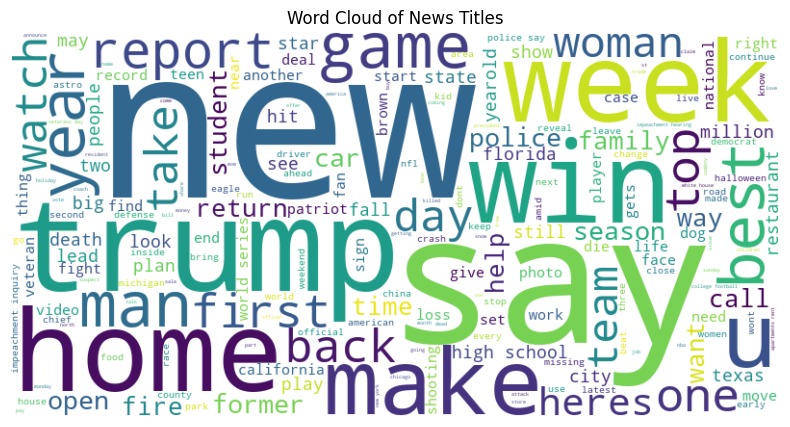

In [24]:
# Word Cloud for Titles
all_words = ' '.join([' '.join(words) for words in news['ProcessedTitle']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Titles')
plt.show()

In [25]:
# Entity Embedding Scatter Plot (using first two dimensions for visualization)
embeddings = np.vstack(news['TitleEntityEmbedding'])
fig = px.scatter(x=embeddings[:, 0], y=embeddings[:, 1], color=news['Category'],
                title='Title Entity Embeddings (First 2 Dimensions)',
                labels={'x': 'Dimension 1', 'y': 'Dimension 2'})
fig.show()

In [26]:
# Print Statistics
print(f"\nTotal News Articles: {len(news)}")
print(f"Total Users: {len(user_profiles)}")
print(f"Average Profile Length: {sum(len(h) for h in user_profiles.values()) / len(user_profiles):.2f}")
print("\nTop 5 Categories:")
print(news['Category'].value_counts().head())
print(f"\nAverage Title NER Entities: {news['TitleNER'].apply(len).mean():.2f}")
print(f"Average Abstract NER Entities: {news['AbstractNER'].apply(len).mean():.2f}")


Total News Articles: 51282
Total Users: 50000
Average Profile Length: 18.30

Top 5 Categories:
Category
news            15774
sports          14510
finance          3107
foodanddrink     2551
lifestyle        2479
Name: count, dtype: int64

Average Title NER Entities: 0.00
Average Abstract NER Entities: 0.00


In [27]:
import zipfile
import glob

# Save news and behaviors normally
news.to_csv('processed_news.csv', index=False)
behaviors.to_csv('processed_behaviors.csv', index=False)

# Save each split batch into its own ZIP file
split_dirs = {
    'train': 'split_data/train/*.pkl',
    'val': 'split_data/val/*.pkl',
    'test': 'split_data/test/*.pkl'
}

for split, pattern in split_dirs.items():
    zip_filename = f"{split}_data.zip"
    with zipfile.ZipFile(zip_filename, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        for file in glob.glob(pattern):
            arcname = os.path.basename(file)
            zipf.write(file, arcname=arcname)

print("All files saved")

All files saved
